<a href="https://colab.research.google.com/github/Kwonjihan/ML-teamproject/blob/main2/Embedding/FINAL_BERT_Embedding_Modified_fixedRatio1.27_rs38.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path='/content/drive/MyDrive/Colab Notebooks/12K IMDB Dataset.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#FINAL_BERT_Embedding_Modified_fixedRatio1_5.ipynb
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import torch
import torch.nn as nn
import torch.optim as optim
from typing import Optional, Tuple
import re

In [ ]:
!pip install NRCLex
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## 감정에 해당하는 토큰 임베딩에 큰 포션을 취하는 방법
- 1. 우선 문장을 토큰화하기 전에 감정이 드러난 단어를 찾는다
- 2. 해당 단어를 버트 토크나이저를 통해 토크나이즈 된 결과를 저장해둔다
- 3. 만약 감정이 있다면 해당 단어가 벡터로 표현되고 합해져서 임베딩 될 때 더 크게 영향을 주도록 한다.

In [ ]:
## 문장에서 단어 감정 추출 예시 ##
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

def analyze_sentence(sentence):
    # 문장을 토큰화
    words = word_tokenize(sentence)

    # VADER 초기화
    analyzer = SentimentIntensityAnalyzer()

    # 감정이 포함된 단어들 저장
    positive_words = []
    negative_words = []

    # 각 단어의 감정 점수 분석
    for word in words:
        score = analyzer.polarity_scores(word)['compound']
        if score > 0:
            positive_words.append(word)
        elif score < 0:
            negative_words.append(word)

    return positive_words, negative_words

# 테스트 문장
sentence = "i wouldn't rent this one even on dollar rental night."
positive_words, negative_words = analyze_sentence(sentence)

print("Positive words:", positive_words)
print("Negative words:", negative_words)


Positive words: []
Negative words: []



## 1.우선 문장을 토큰화하기 전에 감정이 드러난 단어를 찾는다
## 2.해당 단어를 버트 토크나이저를 통해 토크나이즈 된 결과를 저장해둔다

In [ ]:
# 데이터 전처리 #
import itertools
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.analyzer = SentimentIntensityAnalyzer()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = re.sub(r'<[^>]+>', ' ', self.texts[idx])  # HTML 태그 제거
        label = self.labels[idx]

        # 문장을 토큰화하고 감정 점수를 분석
        words = word_tokenize(text)
        sentiment_words = []
        for word in words:
            score = self.analyzer.polarity_scores(word)['compound']
            if score > 0:
                sentiment_words.append(word)
            elif score < 0:
                sentiment_words.append(word)


        # 감정 단어들을 토큰화
        tokenized_sentiment_words = []
        for word in sentiment_words:
            tokenized = self.tokenizer(word, add_special_tokens=False)['input_ids']
            tokenized_sentiment_words.append(tokenized) # 토큰화된 감정단어들

        # '##' 붙은 서브워드 제거
        filtered_tokens = []
        for token_ids in tokenized_sentiment_words:
            tokens = self.tokenizer.convert_ids_to_tokens(token_ids)
            filtered_tokens.extend([token for token in tokens if not token.startswith('##')])

        # 토큰들을 하나의 텍스트로 이어붙이기
        result_text = ' '.join(filtered_tokens)

        # 토큰화 및 인코딩
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )


        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        token_type_ids = encoding['token_type_ids'].squeeze()

        if not result_text:
            result_text = "[PAD]"

        encoding = self.tokenizer(
            result_text,
            add_special_tokens=False,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        sentiment_tokens = encoding['input_ids'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
            'labels': torch.tensor(label, dtype=torch.long),
            #'sentiment_words' :  sentiment_words,
            #'tokenized_sentiment_words' : tokenized_sentiment_words,
            "sentiment_tokens" :  sentiment_tokens,
        }

def load_data(file_path, tokenizer, max_length=512):
    df = pd.read_csv(file_path)
    df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
    texts = df['review'].tolist()   # 리스트 요소 하나에 풀 문장이 들어있음
    labels = df['sentiment'].tolist()
    print(texts[0])
    train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=38)
    print(train_texts[0])

    train_dataset = SentimentDataset(train_texts, train_labels, tokenizer, max_length)
    val_dataset = SentimentDataset(val_texts, val_labels, tokenizer, max_length)

    return train_dataset, val_dataset


In [ ]:
# 토크나이저 초기화
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 데이터 로드
train_dataset, val_dataset = load_data(file_path, tokenizer)

# 데이터 로더 생성
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

In [ ]:
# 데이터셋 전체에서 가장 짧은 길이를 찾는 코드
from transformers import BertTokenizer

# 사전 학습된 BERT 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# 각 항목의 길이를 저장할 딕셔너리 초기화



print(train_dataset[4891])
input_ids = torch.tensor([101, 1045, 2876, 1005, 1056, 9278, 2023, 2028, 2130, 2006,
                          7922, 12635, 2305, 1012, 102, 0, 0, 0, 0, 0,])
decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)

# 결과 출력
print(decoded_text)

{'input_ids': tensor([  101,  1045,  1005,  1049,  1037,  5187,  2095,  1011,  2214,  2267,
         2934,  1012,  1045,  2253,  2007,  2026,  2564,  1998,  2260,  2095,
         2214,  2684,  1012,  2057,  2035,  5632,  1996,  3185,  1012,  1996,
         2143,  2003,  2434,  1010, 25591,  1010,  3435,  1011, 13823,  1998,
         6135, 11951,  1012,  1996,  5436,  2001,  3733,  2438,  2005,  1037,
         2184,  2095,  2214,  2000,  3582,  1010,  2021,  9792,  2100,  2438,
         2000,  2562,  2019,  4639,  4699,  1012,  1045,  2245,  5616,  7031,
         2106,  1037, 21688,  3105,  1998,  1996,  2717,  1997,  1996,  3459,
         2001,  2074,  2986,  1012,  2026,  2069,  6256,  2003,  2008,  1996,
         3050,  3349,  4520,  2020,  2025,  2004,  5875,  2004,  2027,  2323,
         2031,  2042,  1012,  2027,  2020,  8360,  1010,  2021,  2498,  2768,
         2041,  1012,  2006,  1996,  2060,  2192,  1010,  2191,  1011,  2039,
         1010,  9427,  1010,  7497,  1010, 16434, 

In [ ]:
    ## 예시 확인하기 ##
df = pd.read_csv(file_path)
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
texts = df['review'].tolist()
labels = df['sentiment'].tolist()
dataset = SentimentDataset(texts, labels, tokenizer, 512)
"""
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            token_type_ids=batch['token_type_ids'],
            labels=batch['labels'],
            sentiment_tokens=batch['sentiment_tokens']
"""
print("Sample text:", texts[3])
sample_item = dataset[19]
print("Tokenized input IDs:", sample_item['input_ids'].tolist())
print("Tokenized tokens:", tokenizer.convert_ids_to_tokens(sample_item['input_ids'].tolist()))
print("Tokenized attention mask:", sample_item['attention_mask'].tolist())
print("Tokenized token type IDs:", sample_item['token_type_ids'].tolist())
print("Label:", sample_item['labels'].item())
print('sentiment_words:', sample_item['sentiment_words'])
print('Tokenized sentiment words:',sample_item['tokenized_sentiment_words'])

# 토큰화된 감정 단어들 출력
tokenized_sentiment_words = sample_item['tokenized_sentiment_words']
all_tokens = []
filtered_all_tokens = []

for token_ids in tokenized_sentiment_words:
        tokens = tokenizer.convert_ids_to_tokens(token_ids)
        filtered_tokens = [token for token in tokens if not token.startswith('##')]
        filtered_all_tokens.append(filtered_tokens)
        all_tokens.append(tokens)

print('## removed Tokenized sentiment words :', filtered_all_tokens)
print(len(sample_item['input_ids']))
print(len(sample_item['attention_mask']))
print(len(sample_item['token_type_ids']))
print(len(sample_item["attention_mask"]))
print(len(sample_item["sentiment_tokens"]))
    ##===============##

Sample text: Petter Mattei's "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of contact. Stylishly, the film has a sophisticated luxurious look. We are taken to see how these people live and the world they live in their own habitat.<br /><br />The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits. A big city is not exactly the best place in which human relations find sincere fulfillment, as one discerns is th

KeyError: 'sentiment_words'

In [ ]:
# [모델 준비] #

# 활성화 함수
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

# 활성화 함수 매핑
ACT2FN = {"gelu": gelu, "relu": torch.nn.functional.relu, "swish": torch.nn.functional.silu}

# 모델 설정

class BertEmbeddings(nn.Module):
    def __init__(self, config):
    #def __init__(self, config: Config, sentiment_ratio_init: float = 1.5):
        super().__init__()
        # 단어 임베딩, 위치 임베딩, 토큰 타입 임베딩
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

        # 레이어 정규화와 드롭아웃
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)), persistent=False)
        self.register_buffer("token_type_ids", torch.zeros(self.position_ids.size(), dtype=torch.long), persistent=False)

        # 학습 가능한 sentiment_ratio 파라미터 추가 및 초기값 설정
        #self.sentiment_ratio = nn.Parameter(torch.tensor(sentiment_ratio_init))

    def forward(self, input_ids=None, token_type_ids=None, position_ids=None, inputs_embeds=None, past_key_values_length=0, sentiment_tokens=None):
        if input_ids is not None:
            input_shape = input_ids.size()
        else:
            input_shape = inputs_embeds.size()[:-1]

        seq_length = input_shape[1]

        if position_ids is None:
            position_ids = self.position_ids[:, past_key_values_length: seq_length + past_key_values_length]

        if token_type_ids is None:
            if hasattr(self, "token_type_ids"):
                buffered_token_type_ids = self.token_type_ids[:, :seq_length]
                buffered_token_type_ids_expanded = buffered_token_type_ids.expand(input_shape[0], seq_length)
                token_type_ids = buffered_token_type_ids_expanded
            else:
                token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=self.position_ids.device)

        if inputs_embeds is None:
            inputs_embeds = self.word_embeddings(input_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        # 입력 임베딩 생성
        embeddings = inputs_embeds + token_type_embeddings

        for i in range(input_ids.size(0)):  # 배치의 각 문장에 대해
            sentiment_token = sentiment_tokens[i]
            sentiment_token_filtered = sentiment_token[(sentiment_token != 0) & (sentiment_token != 101) & (sentiment_token != 102)]
            for j in range(input_ids.size(1)):  # 각 문장의 각 토큰에 대해
                if input_ids[i, j] in sentiment_token_filtered:
                    # 파라미터로 사용시
                    #embeddings[i, j] = self.sentiment_ratio * inputs_embeds[i, j] + token_type_embeddings[i, j]
                    #print("sentiment token ratio : ",self.sentiment_ratio)
                #if j == 0 and i == 0:
                    #print("Sentiment ratio for this batch: ", self.sentiment_ratio.item())
                    # 정해줄 때
                    embeddings[i, j] = 1.27 * inputs_embeds[i, j] + token_type_embeddings[i, j]

        if self.position_embedding_type == "absolute":
            position_embeddings = self.position_embeddings(position_ids)
            embeddings += position_embeddings

        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings


# 셀프 어텐션 구현 클래스
class BertSelfAttention(nn.Module):
    def __init__(self, config, position_embedding_type=None):
        super().__init__()
        # hidden_size가 num_attention_heads의 배수가 아니면 오류 발생
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )

        # 어텐션 헤드의 수와 각 헤드의 크기, 전체 헤드 크기 설정
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(
            config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # Query, Key, Value 행렬 정의
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        # 드롭아웃 레이어 정의
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        # 위치 임베딩 유형 설정
        self.position_embedding_type = position_embedding_type or getattr(
            config, "position_embedding_type", "absolute"
        )
        # 상대적 위치 임베딩을 사용하는 경우, 위치 임베딩 레이어 정의
        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            self.max_position_embeddings = config.max_position_embeddings
            self.distance_embedding = nn.Embedding(
                2 * config.max_position_embeddings - 1, self.attention_head_size)

        # 디코더인지 여부 설정
        self.is_decoder = config.is_decoder

    def transpose_for_scores(self, x: torch.Tensor) -> torch.Tensor:
        # 텐서의 크기 변환
        new_x_shape = x.size()[
            :-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(new_x_shape)
        # 텐서의 차원 변경 [batch_size, num_heads, seq_len, head_size]
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        # Query 레이어 계산
        mixed_query_layer = self.query(hidden_states)

        # 크로스 어텐션인지 여부 확인
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:
            # 과거의 k, v 값을 재사용 (크로스 어텐션)
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
        elif is_cross_attention:
            # 인코더의 키와 값을 사용하여 크로스 어텐션 수행
            key_layer = self.transpose_for_scores(
                self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(
                self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        elif past_key_value is not None:
            # 과거의 k, v 값을 현재의 k, v와 결합 (디코더의 셀프 어텐션)
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:
            # 현재의 히든 스테이트에서 키와 값을 계산 (셀프 어텐션)
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        # Query 레이어 변환
        query_layer = self.transpose_for_scores(mixed_query_layer)

        # 캐시를 사용할지 여부 설정
        use_cache = past_key_value is not None
        if self.is_decoder:
            # 디코더인 경우, 키와 값을 캐싱
            past_key_value = (key_layer, value_layer)

        # Query와 Key의 내적(dot product)을 통해 어텐션 스코어 계산
        attention_scores = torch.matmul(
            query_layer, key_layer.transpose(-1, -2))

        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            # 상대적 위치 임베딩을 사용하는 경우
            query_length, key_length = query_layer.shape[2], key_layer.shape[2]
            if use_cache:
                position_ids_l = torch.tensor(key_length - 1, dtype=torch.long, device=hidden_states.device).view(
                    -1, 1
                )
            else:
                position_ids_l = torch.arange(
                    query_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
            position_ids_r = torch.arange(
                key_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
            distance = position_ids_l - position_ids_r

            # 거리 임베딩 계산
            positional_embedding = self.distance_embedding(
                distance + self.max_position_embeddings - 1)
            positional_embedding = positional_embedding.to(
                dtype=query_layer.dtype)  # fp16 호환성

            if self.position_embedding_type == "relative_key":
                # 상대적 위치 임베딩을 쿼리에 적용
                relative_position_scores = torch.einsum(
                    "bhld,lrd->bhlr", query_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                # 상대적 위치 임베딩을 쿼리와 키에 적용
                relative_position_scores_query = torch.einsum(
                    "bhld,lrd->bhlr", query_layer, positional_embedding)
                relative_position_scores_key = torch.einsum(
                    "bhrd,lrd->bhlr", key_layer, positional_embedding)
                attention_scores = attention_scores + \
                    relative_position_scores_query + relative_position_scores_key

        # 어텐션 스코어를 정규화
        attention_scores = attention_scores / \
            math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # 어텐션 마스크 적용
            attention_scores = attention_scores + attention_mask

        # 어텐션 스코어를 확률로 변환
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # 드롭아웃 적용
        attention_probs = self.dropout(attention_probs)

        # 헤드 마스크 적용
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        # 컨텍스트 레이어 계산
        context_layer = torch.matmul(attention_probs, value_layer)

        # 텐서의 크기 변환 및 재배치
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[
            :-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        # 출력 생성
        outputs = (context_layer, attention_probs) if output_attentions else (
            context_layer,)

        # 디코더인 경우, past_key_value를 출력에 포함
        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs


# 셀프 어텐션 출력 처리 클래스
class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        # 드롭아웃, 레이어 정규화, 잔차 연결 적용
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

# 어텐션 메커니즘 클래스
class BertAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self = BertSelfAttention(config)
        self.output = BertSelfOutput(config)

    def forward(self, input_tensor, attention_mask=None, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None, past_key_value=None, output_attentions=False):
        # 셀프 어텐션 및 출력 계산
        self_outputs = self.self(
            input_tensor,
            attention_mask,
            head_mask,
            encoder_hidden_states,
            encoder_attention_mask,
            past_key_value,
            output_attentions,
        )
        attention_output = self.output(self_outputs[0], input_tensor)
        outputs = (attention_output,) + self_outputs[1:]
        return outputs

# 중간 레이어 활성화 함수 클래스
class BertIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        self.intermediate_act_fn = ACT2FN[config.hidden_act]

    def forward(self, hidden_states):
        # 중간 레이어 활성화 함수 적용
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states

# 중간 레이어 출력 처리 클래스
class BertOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        # 드롭아웃, 레이어 정규화, 잔차 연결 적용
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.Layer

    def forward(self, hidden_states, input_tensor):
        # 드롭아웃, 레이어 정규화, 잔차 연결 적용
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

# 하나의 BERT 레이어를 구현하는 클래스
class BertLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(self, hidden_states, attention_mask=None, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None, past_key_value=None, output_attentions=False):
        # 어텐션과 출력 계산
        self_attention_outputs = self.attention(
            hidden_states,
            attention_mask,
            head_mask,
            encoder_hidden_states,
            encoder_attention_mask,
            past_key_value,
            output_attentions=output_attentions,
        )
        attention_output = self_attention_outputs[0]
        layer_output = self.output(self.intermediate(attention_output), attention_output)
        outputs = (layer_output,) + self_attention_outputs[1:]
        return outputs

# 여러 BERT 레이어를 포함하는 인코더 클래스
class BertEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer = nn.ModuleList([BertLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(self, hidden_states, attention_mask=None, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None, past_key_values=None, use_cache=None, output_attentions=False, output_hidden_states=False, return_dict=True):
        all_hidden_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None
        for i, layer_module in enumerate(self.layer):
            layer_head_mask = head_mask[i] if head_mask is not None else None
            past_key_value = past_key_values[i] if past_key_values is not None else None

            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_outputs = layer_module(
                hidden_states,
                attention_mask,
                layer_head_mask,
                encoder_hidden_states,
                encoder_attention_mask,
                past_key_value,
                output_attentions,
            )
            hidden_states = layer_outputs[0]

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],)

        return (hidden_states, all_hidden_states, all_attentions)

# 첫 번째 토큰의 출력을 풀링하는 클래스
class BertPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # 첫 번째 토큰의 텐서를 사용해 풀링 출력 생성
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

# 전체 BERT 모델을 구현하는 클래스
class  userBertModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, inputs_embeds=None, encoder_hidden_states=None, encoder_attention_mask=None, past_key_values=None, use_cache=None, output_attentions=None, output_hidden_states=None, return_dict=None, sentiment_tokens=None):
        # 입력 텐서의 크기 확인
        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("input_ids 혹은 inputs_embeds 둘 중 하나의 형식으로만 입력해야 합니다.")
        elif input_ids is not None:
            input_shape = input_ids.size()
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            raise ValueError("input_ids 또는 inputs_embeds의 형식이어야 합니다.")

        device = input_ids.device if input_ids is not None else inputs_embeds.device
        if attention_mask is None:
            attention_mask = torch.ones(input_shape, device=device)
        if token_type_ids is None:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

        extended_attention_mask = attention_mask[:, None, None, :]
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        head_mask = [None] * self.config.num_hidden_layers

        # 임베딩 출력 계산
        embedding_output = self.embeddings(
            input_ids=input_ids,
            position_ids=position_ids,
            token_type_ids=token_type_ids,
            inputs_embeds=inputs_embeds,
            sentiment_tokens= sentiment_tokens,
        )
        # 인코더 출력 계산
        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output)
        return sequence_output, pooled_output

In [ ]:
from transformers import BertModel, BertConfig
from tqdm import tqdm
# 위 구조를 취합하여 만든 이진 감정 분류를 위한 클래스
class BertForSequenceClassification(nn.Module):
    def __init__(self, config, num_labels):
        super(BertForSequenceClassification, self).__init__()
        self.bert = userBertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None, sentiment_tokens=None):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            sentiment_tokens= sentiment_tokens,
        )
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, 2), labels.view(-1))

        return loss, logits

# Pretrained BERT 모델 로드

pretrained_model = BertModel.from_pretrained('bert-base-uncased')
pretrained_state_dict = pretrained_model.state_dict()

# Custom 모델 초기화
custom_config = BertConfig(
    vocab_size=30522,
    hidden_size=768,
    num_hidden_layers=8,
    num_attention_heads=12, # 수정된 부분
    intermediate_size=3072, # 수정된 부분
    hidden_act="gelu",
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    max_position_embeddings=512,
    type_vocab_size=2,
    initializer_range=0.02,
    layer_norm_eps=1e-12,
    pad_token_id=0,
    gradient_checkpointing=False,
    position_embedding_type="absolute",
    use_cache=True
)
model = BertForSequenceClassification(custom_config, num_labels=2)

# Pretrained 모델의 state_dict를 Custom 모델로 로드
model.bert.load_state_dict(pretrained_state_dict, strict=False)



# 옵티마이저 설정
optimizer = optim.AdamW(model.parameters(), lr=5e-6)

# 학습 진행
model.train()
for epoch in tqdm(range(3)):
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0
    for batch_idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            token_type_ids=batch['token_type_ids'],
            labels=batch['labels'],
            sentiment_tokens=batch['sentiment_tokens']
        )
        loss, logits = outputs
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # 예측값 계산
        _, predicted = torch.max(logits, 1)
        correct_predictions += (predicted == batch['labels']).sum().item()
        total_predictions += batch['labels'].size(0)

        if batch_idx % 10 == 0:  # 10번째 배치마다 현황 출력
            batch_accuracy = correct_predictions / total_predictions
            print(f"Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}, Accuracy: {batch_accuracy}")

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    epoch_accuracy = correct_predictions / total_predictions
    print(f"Epoch: {epoch} finished with average loss: {avg_epoch_loss}, Accuracy: {epoch_accuracy}")

# 예측 확률 계산 및 평가 수행
all_logits = []
all_labels = []
model.eval()
epoch_loss = 0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for batch_idx, batch in enumerate(val_dataloader):
        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            token_type_ids=batch['token_type_ids'],
            labels=batch['labels'],
            sentiment_tokens=batch['sentiment_tokens']
        )
        loss, logits = outputs
        epoch_loss += loss.item()

        # 예측값 계산
        _, predicted = torch.max(logits, 1)
        correct_predictions += (predicted == batch['labels']).sum().item()
        total_predictions += batch['labels'].size(0)

        all_logits.append(logits)
        all_labels.append(batch['labels'])

        if batch_idx % 10 == 0:  # 10번째 배치마다 현황 출력
            batch_accuracy = correct_predictions / total_predictions
            print(f"Epoch: TEST , Batch: {batch_idx}, Loss: {loss.item()}, Accuracy: {batch_accuracy}")

    avg_epoch_loss = epoch_loss / len(val_dataloader)
    epoch_accuracy = correct_predictions / total_predictions
    print(f"Test iteration finished with average loss: {avg_epoch_loss}, Accuracy: {epoch_accuracy}")

# 예측 확률 및 라벨 병합
all_logits = torch.cat(all_logits).cpu().numpy()
all_labels = torch.cat(all_labels).cpu().numpy()

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0, Batch: 0, Loss: 0.7834900617599487, Accuracy: 0.4375
Epoch: 0, Batch: 10, Loss: 0.6821764707565308, Accuracy: 0.5
Epoch: 0, Batch: 20, Loss: 0.6695274710655212, Accuracy: 0.5357142857142857
Epoch: 0, Batch: 30, Loss: 0.7144859433174133, Accuracy: 0.5221774193548387
Epoch: 0, Batch: 40, Loss: 0.7235970497131348, Accuracy: 0.5167682926829268
Epoch: 0, Batch: 50, Loss: 0.687125563621521, Accuracy: 0.5220588235294118
Epoch: 0, Batch: 60, Loss: 0.7080927491188049, Accuracy: 0.5276639344262295
Epoch: 0, Batch: 70, Loss: 0.7373039126396179, Accuracy: 0.5202464788732394
Epoch: 0, Batch: 80, Loss: 0.7094631791114807, Accuracy: 0.5231481481481481
Epoch: 0, Batch: 90, Loss: 0.612076461315155, Accuracy: 0.5260989010989011
Epoch: 0, Batch: 100, Loss: 0.666999876499176, Accuracy: 0.5235148514851485
Epoch: 0, Batch: 110, Loss: 0.7322025895118713, Accuracy: 0.5242117117117117
Epoch: 0, Batch: 120, Loss: 0.6363598704338074, Accuracy: 0.5340909090909091
Epoch: 0, Batch: 130, Loss: 0.6044777631

 33%|███▎      | 1/3 [1:01:31<2:03:02, 3691.14s/it]

Epoch: 0 finished with average loss: 0.45446270059794186, Accuracy: 0.7652083333333334
Epoch: 1, Batch: 0, Loss: 0.5437594056129456, Accuracy: 0.75
Epoch: 1, Batch: 10, Loss: 0.11078078299760818, Accuracy: 0.9090909090909091
Epoch: 1, Batch: 20, Loss: 0.1610330194234848, Accuracy: 0.9077380952380952
Epoch: 1, Batch: 30, Loss: 0.1723083108663559, Accuracy: 0.9032258064516129
Epoch: 1, Batch: 40, Loss: 0.3200484812259674, Accuracy: 0.8978658536585366
Epoch: 1, Batch: 50, Loss: 0.229256734251976, Accuracy: 0.8921568627450981
Epoch: 1, Batch: 60, Loss: 0.2572537064552307, Accuracy: 0.8924180327868853
Epoch: 1, Batch: 70, Loss: 0.21688763797283173, Accuracy: 0.8882042253521126
Epoch: 1, Batch: 80, Loss: 0.1823032945394516, Accuracy: 0.8888888888888888
Epoch: 1, Batch: 90, Loss: 0.12809982895851135, Accuracy: 0.8949175824175825
Epoch: 1, Batch: 100, Loss: 0.18061551451683044, Accuracy: 0.8941831683168316
Epoch: 1, Batch: 110, Loss: 0.4053176939487457, Accuracy: 0.893581081081081
Epoch: 1, Ba

 67%|██████▋   | 2/3 [2:04:12<1:02:12, 3732.67s/it]

Epoch: 1 finished with average loss: 0.23061690949834884, Accuracy: 0.9125
Epoch: 2, Batch: 0, Loss: 0.29140225052833557, Accuracy: 0.875
Epoch: 2, Batch: 10, Loss: 0.0877600759267807, Accuracy: 0.9545454545454546
Epoch: 2, Batch: 20, Loss: 0.11082682013511658, Accuracy: 0.9404761904761905
Epoch: 2, Batch: 30, Loss: 0.038034405559301376, Accuracy: 0.9354838709677419
Epoch: 2, Batch: 40, Loss: 0.278556227684021, Accuracy: 0.9329268292682927
Epoch: 2, Batch: 50, Loss: 0.17385593056678772, Accuracy: 0.9362745098039216
Epoch: 2, Batch: 60, Loss: 0.09873208403587341, Accuracy: 0.9375
Epoch: 2, Batch: 70, Loss: 0.11344553530216217, Accuracy: 0.9348591549295775
Epoch: 2, Batch: 80, Loss: 0.11692970246076584, Accuracy: 0.9320987654320988
Epoch: 2, Batch: 90, Loss: 0.08063854277133942, Accuracy: 0.9347527472527473
Epoch: 2, Batch: 100, Loss: 0.06176077947020531, Accuracy: 0.932549504950495
Epoch: 2, Batch: 110, Loss: 0.38997307419776917, Accuracy: 0.9346846846846847
Epoch: 2, Batch: 120, Loss: 

100%|██████████| 3/3 [3:09:57<00:00, 3799.01s/it]

Epoch: 2 finished with average loss: 0.1636634593550116, Accuracy: 0.9401041666666666


Epoch: TEST , Batch: 0, Loss: 0.2525942623615265, Accuracy: 0.9375
Epoch: TEST , Batch: 10, Loss: 0.18795081973075867, Accuracy: 0.9261363636363636
Epoch: TEST , Batch: 20, Loss: 0.5142763257026672, Accuracy: 0.9255952380952381
Epoch: TEST , Batch: 30, Loss: 0.22284677624702454, Accuracy: 0.9274193548387096
Epoch: TEST , Batch: 40, Loss: 0.017945926636457443, Accuracy: 0.9222560975609756
Epoch: TEST , Batch: 50, Loss: 0.6091195940971375, Accuracy: 0.9215686274509803
Epoch: TEST , Batch: 60, Loss: 0.4440571069717407, Accuracy: 0.9180327868852459
Epoch: TEST , Batch: 70, Loss: 0.02194654941558838, Accuracy: 0.9181338028169014
Epoch: TEST , Batch: 80, Loss: 0.20216654241085052, Accuracy: 0.9182098765432098
Epoch: TEST , Batch: 90, Loss: 0.25108271837234497, Accuracy: 0.9182692307692307
Epoch: TEST , Batch: 100, Loss: 0.038889072835445404, Accuracy: 0.9189356435643564
Epoch: TEST , Batch: 110, Loss: 0.230738565325737, Accuracy: 0.9211711711711712
Epoch: TEST , Batch: 120, Loss: 0.351978391

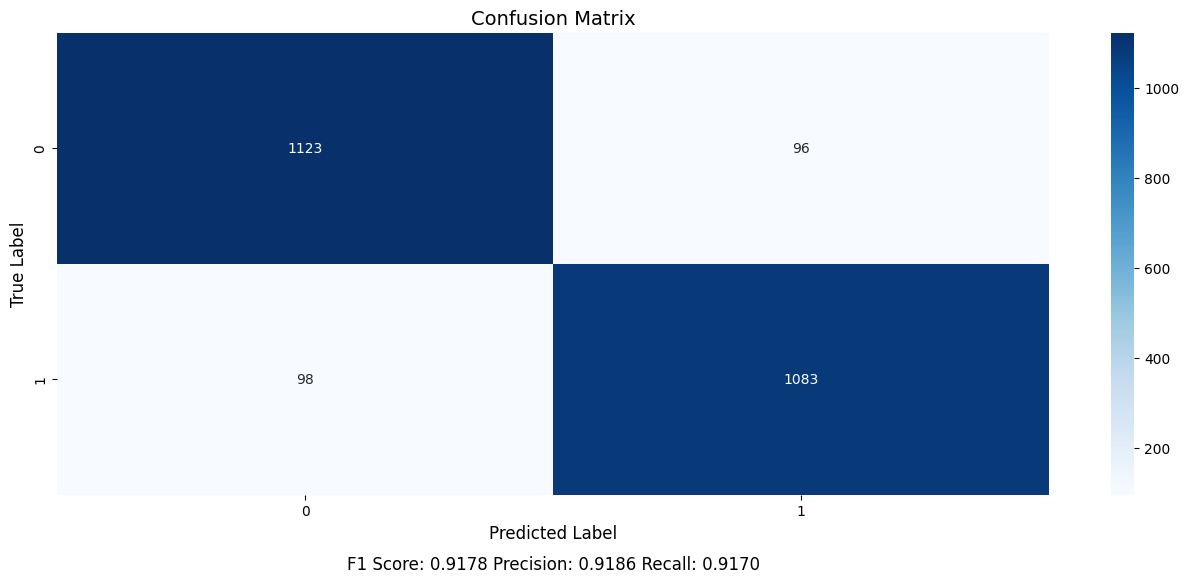

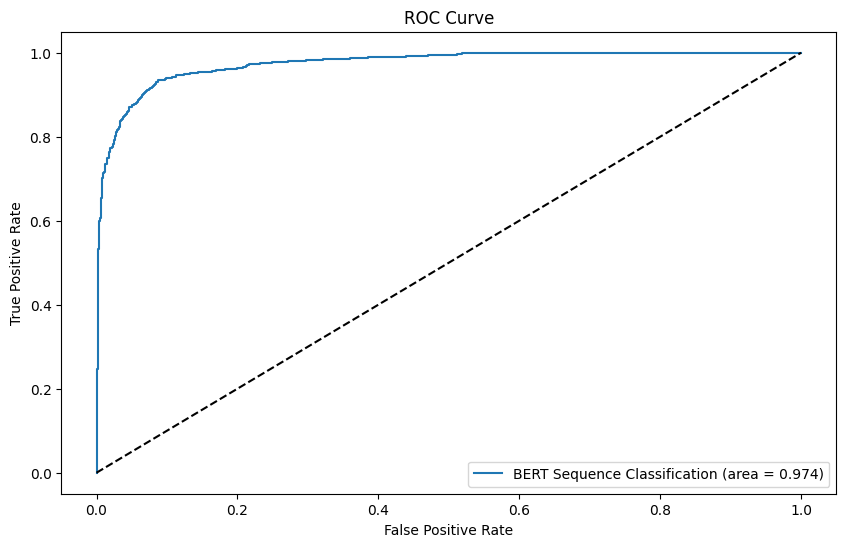

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
# ROC 곡선 및 AUC 계산
lr_proba = torch.softmax(torch.tensor(all_logits), dim=1)[:, 1].numpy()
fp_lr, tp_lr, _ = roc_curve(all_labels, lr_proba, pos_label=1)
auroc_baseline = roc_auc_score(all_labels, lr_proba)

# 예측값 계산
y_pred = np.argmax(all_logits, axis=1)

# 성능 지표 계산
cm1 = confusion_matrix(all_labels, y_pred)
f1_1 = f1_score(all_labels, y_pred, pos_label=1)
precision_1 = precision_score(all_labels, y_pred, pos_label=1)
recall_1 = recall_score(all_labels, y_pred, pos_label=1)

# 혼동 행렬 및 성능 지표 시각화
fig, axes = plt.subplots(figsize=(16, 6))
sns.heatmap(cm1, annot=True, cmap='Blues', fmt='d', ax=axes)
axes.set_title('Confusion Matrix', fontsize=14)
axes.set_xlabel('Predicted Label', fontsize=12)
axes.set_ylabel('True Label', fontsize=12)
axes.text(0.5, -0.15, f'F1 Score: {f1_1:.4f} Precision: {precision_1:.4f} Recall: {recall_1:.4f}',
          horizontalalignment='center', verticalalignment='center', transform=axes.transAxes, fontsize=12)
plt.show()

# ROC 곡선 그리기
plt.figure(figsize=(10, 6))
plt.plot(fp_lr, tp_lr, label=f'BERT Sequence Classification (area = {auroc_baseline:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

